In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hms-harmful-brain-activity-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F59093%2F7469972%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T184139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da4cf6fa91eaa4a1190c48b8da76f336a0f01626edeaf69828f8c63aa7560ef349d0cc2e8955335720b2c6004f04b2e0c9346a311ca496a7d3f4d422a92a0bad6090d3575096ae2096ad9274a95907f2da75da3a88b3a9c203bcff1149f1942564a64a98ca09635622b03e7d4ca703a1ae2c95ced53fb48b921536454e17f0206066b88a098fabe9b8db551f167ebc069f9bb32e9fe5fe9ab4142e0539b9b143784165171fc9628ca8cb3300510065be28f8b0ba1dc6da67c291361c5430ca6b83439a52876193b2ffa9443ef9d4e18022b69fcf386183446ab6360ad865780f02c1067eb67e3eda8d81de2dc36abb5bbb4b95a24fc2e722cdcbe54a372d5a87f,kerasv3-lib-ds:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4308295%2F7526248%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T184139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93c4ff8903e64f75953c3db067cd0e73f3e06b48ca473286c8bd0018aa062240e21abb29d782802cf11f5036c93f095715aaa2f2210114f0dfffb6ffed55cfa4bb777bf2056523569f1aeb18be0d4da9bf96f857b8505e538855c5d1694d4708e58d11327bd973a0ed719ee8ca3af167e2df73a6c8c32dbb28a11bda63226f04e964e606eb239016da4c2d1d5ddcbea65ce24804851d29b9695e5a41c92f03d2bb357e95812a5646c89b4fc3c848d716b2ed324b74fa786131faddf5577736041d6ebb889c427b5d785f748d85316118d162fa06f3933cf54870e9f5ac0650ac887cbdbb92baa5f44541e46a85d49a8e8100a247907bc0fc5dd6f9c17211748a,efficientnetv2/keras/efficientnetv2_b2_imagenet/2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F4598%2F6127%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T184139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De486a96219aa6e2bb98ef3121773a4b9a39df8cf3e72ef2ba9b9c900c8c73fffa8e75f83d782f416f59ad14caf2f606552e85e16e18fdd16ec6a225bb1ab4b57ab60e6d232bedaf6aea64ec12af9cba6e1c5cc019f0e30e01f1c5017d061005be16a181f5bcbf3b3f330f105fadafba4e237d35543fa613d4b93990382933f17854e09a5bf5574c9e54f7c386a55be90153e2a5f6f3a85a394193f9ed817aef4a53d1efc20fbe96c19915dc85e0f13048b198cbe4c9537d9b4a4b560425e09ccebed6eb07b7c2bff4cfd1575a764416491a35d30f7da5049f1726e97e708b9aa7052f620effc29b8a2f337132b31ecd0e6a1be3b9898359e0d6923d952067885'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 19762787900 bytes downloaded
Downloaded and uncompressed: hms-harmful-brain-activity-classification
[==================================================] 519822167 bytes downloaded
Downloaded and uncompressed: kerasv3-lib-ds
[==================================================] 32659110 bytes downloaded
Downloaded and uncompressed: efficientnetv2/keras/efficientnetv2_b2_imagenet/2
Data source import complete.


# HMS - Harmful Brain Activity Classification

> The objective of this notrbook is to classify seizures and other patterns of harmful brain activity in critically ill patients

This project has the foollowing objectives
* Loading the data efficiently using [`tf.data`](https://www.tensorflow.org/guide/data).
* Creating the model using KerasCV presets.
* Training the model.
* Inference and Submission on test data.


## Import Libraries

In [2]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.7 MB/s eta 0:00:00


In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import tensorflow as tf
import keras_cv
import keras

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # python library for progress bar
import joblib

import matplotlib.pyplot as plt

In [2]:
print("TensorFlow:", tf.__version__)
print("KerasCV:", keras_cv.__version__) # Check for compatibility
print("Keras:", keras.__version__)

TensorFlow: 2.15.0
KerasCV: 0.8.2
Keras: 3.0.4


## Config

In [22]:
class Config:
    fold = 0 # Which fold to set as validation data
    randSeed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    batchSize = 64  # Batch size
    verbosity = 2  # Verbosity
    dropRem = True  # Drop incomplete batches
    epochs = 20 # Training epochs
    lrMode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    numClasses = 6 # Number of classes in the dataset
    imageSize = [400, 300]  # Input image size
    classNames = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(classNames))
    name2label = {v:k for k, v in label2name.items()}

# Set a value for the random seed to be able to reproduce a speciffic outcome.
keras.utils.set_random_seed(Config.randSeed)

## Dataset Path

In [4]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)
## Meta Data
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(Config.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


## Convert `.parquet` to `.npy`

To facilitate easier data loading, we will convert the EEG spectrograms from `parquet` to `npy` format. This process involves saving the spectrogram data, and since the content of the files remains the same, no significant changes are made.

In [5]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## DataLoader

This DataLoader first reads `npy` spectrogram files and extracts labeled subsamples using specified `offset` values. Then, it converts the spectrogram data into `log spectrogram` and applies the popular signal augmentation `MixUp`.

Note: we are converting the mono channel signal to a 3-channel signal for using "ImageNet" weights of pretrained model.

In [6]:
def build_augmenter(dim=Config.imageSize):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment


def build_decoder(with_labels=True, target_size=Config.imageSize, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])

        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None:
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]

            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])

        # Log spectrogram
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)

        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6

        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig

    def decode_label(label):
        label = tf.one_hot(label, Config.numClasses)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [Config.numClasses])
        return label

    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)

    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024,
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=Config.randSeed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Data Split

In the following code snippet, the data is divided into `5` folds. Note that, the `groups` argument is used to prevent any overlap of patients between the training and validation sets, thus avoiding potential **data leakage** issues. Additionally, each split is stratified based on the `class_label`, ensuring a uniform distribution of class labels in each fold.

In [7]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=Config.randSeed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Build Train & Valid Dataset

Only first sample for each `spectrogram_id` is used in order to keep the dataset size managable. Feel free to train on full data.

In [8]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)

train_df = sample_df[sample_df.fold != Config.fold]
valid_df = sample_df[sample_df.fold == Config.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=Config.batchSize,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=Config.batchSize,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


## Dataset Check

Let's visualize some samples from the dataset.

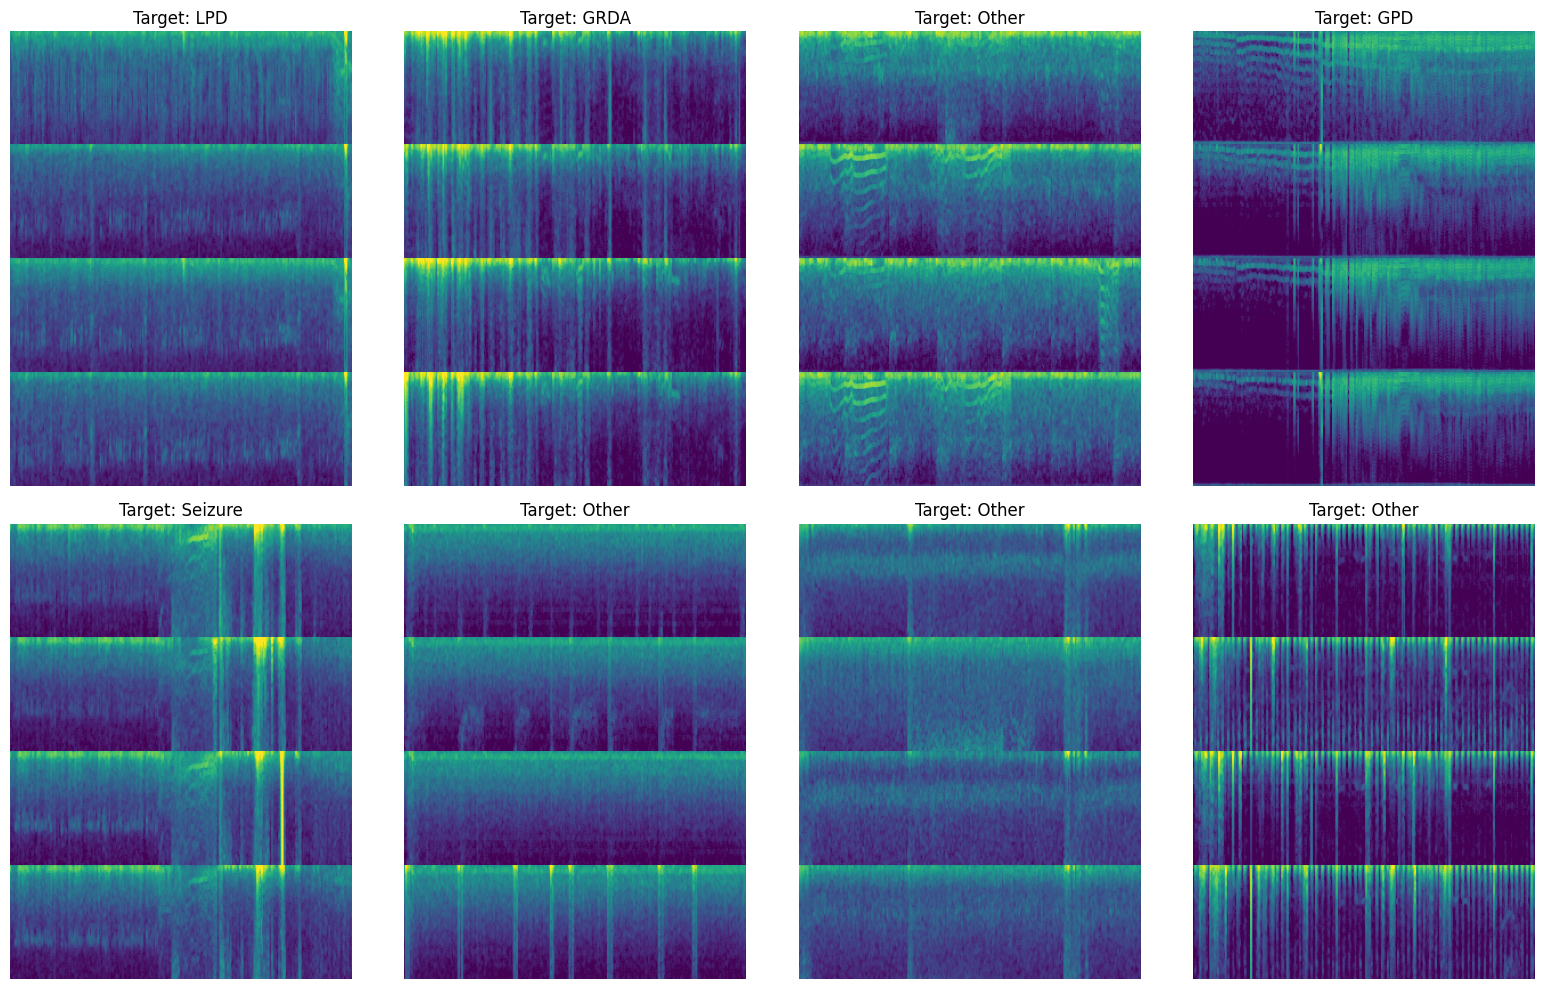

In [9]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = Config.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Loss & Metric

The evaluation metric in this is **KL Divergence**, defined as,

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- $P$ is the true distribution.
- $Q$ is the predicted distribution.

Interestingly, as KL Divergence is differentiable, we can directly use it as our loss function. Thus, we don't need to use a third-party metric like **Accuracy** to evaluate our model. Therefore, `valid_loss` can stand alone as an indicator for our evaluation. In keras, we already have impelementation for KL Divergence loss.

In [10]:
LOSS = keras.losses.KLDivergence()

## Modeling

We use the `EfficientNetV2 B2` from KerasCV's collection of pretrained models. To change this modify the `preset` in the `Config`. <br>
[KerasCV website](https://keras.io/api/keras_cv/models/tasks/image_classifier/)

In [23]:
# Build Classifier
model = keras_cv.models.ImageClassifier.from_preset(Config.preset, num_classes=Config.numClasses)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=LOSS, metrics=['accuracy'])

# Model Sumamry
model.summary()

Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)         │ (None, None, None, 3)         │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ efficient_net_v2b2_backbone        │ (None, None, None, 1408)      │   8,769,374 │
│ (EfficientNetV2Backbone)           │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ avg_pool (GlobalAveragePooling2D)  │ (None, 1408)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ predictions (Dense)                │ (None, 6)                     │       8,454 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

## LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [25]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

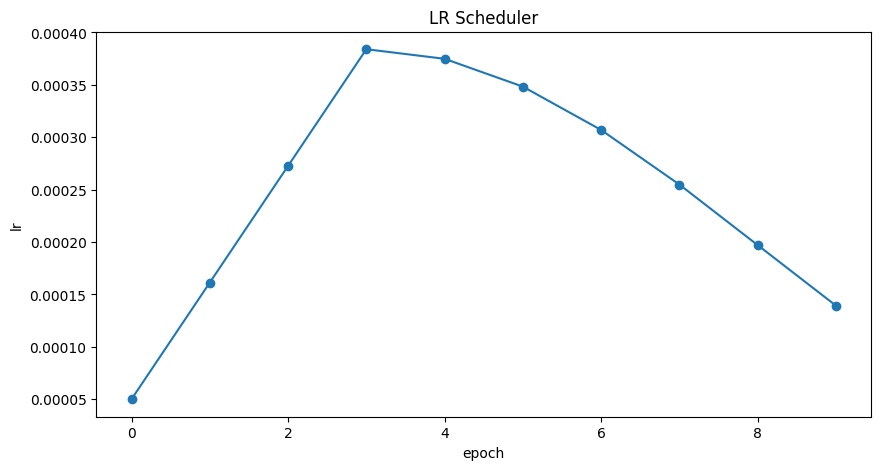

In [26]:
lr_cb = get_lr_callback(Config.batchSize, mode=Config.lrMode, plot=True)

## Model Checkpointing

In [27]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min')

## Training

In [28]:
history = model.fit(train_ds, epochs=Config.epochs, callbacks=[lr_cb, ckpt_cb], steps_per_epoch=len(train_df)//Config.batchSize, validation_data=valid_ds, verbose=Config.verbosity)

Epoch 1/20
143/143 - 128s - 892ms/step - accuracy: 0.3936 - loss: 1.3460 - val_accuracy: 0.5051 - val_loss: 1.3580 - learning_rate: 5.0000e-05
Epoch 2/20
143/143 - 54s - 376ms/step - accuracy: 0.5250 - loss: 1.0923 - val_accuracy: 0.5958 - val_loss: 1.0990 - learning_rate: 1.6133e-04
Epoch 3/20
143/143 - 53s - 369ms/step - accuracy: 0.6046 - loss: 0.9548 - val_accuracy: 0.6466 - val_loss: 0.9849 - learning_rate: 2.7267e-04
Epoch 4/20
143/143 - 52s - 366ms/step - accuracy: 0.6329 - loss: 0.8799 - val_accuracy: 0.6775 - val_loss: 0.9025 - learning_rate: 3.8400e-04
Epoch 5/20
143/143 - 52s - 367ms/step - accuracy: 0.6576 - loss: 0.8337 - val_accuracy: 0.6942 - val_loss: 0.8679 - learning_rate: 3.7485e-04
Epoch 6/20
143/143 - 51s - 359ms/step - accuracy: 0.6767 - loss: 0.7783 - val_accuracy: 0.6846 - val_loss: 0.9241 - learning_rate: 3.4829e-04
Epoch 7/20
143/143 - 53s - 368ms/step - accuracy: 0.6996 - loss: 0.7336 - val_accuracy: 0.6998 - val_loss: 0.8603 - learning_rate: 3.0692e-04
Epoch

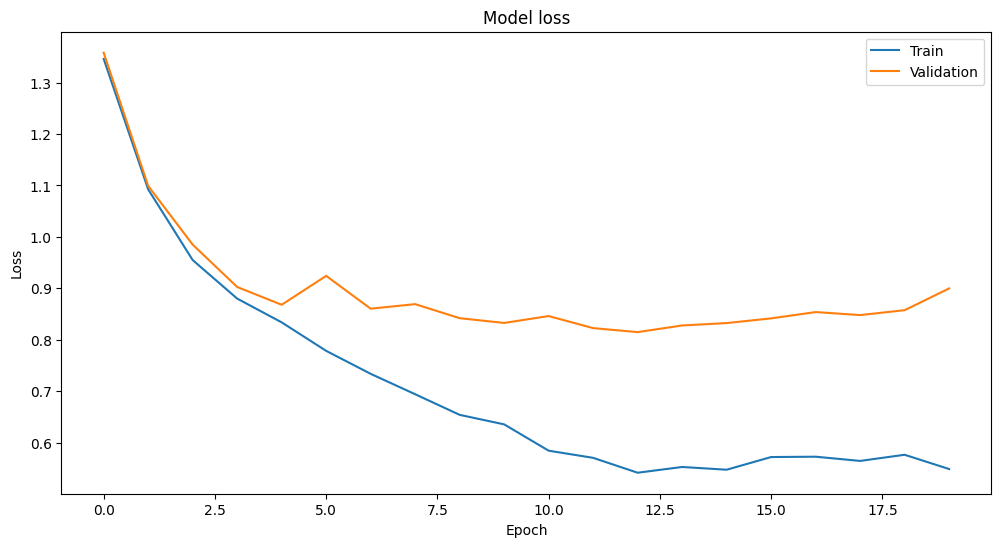

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

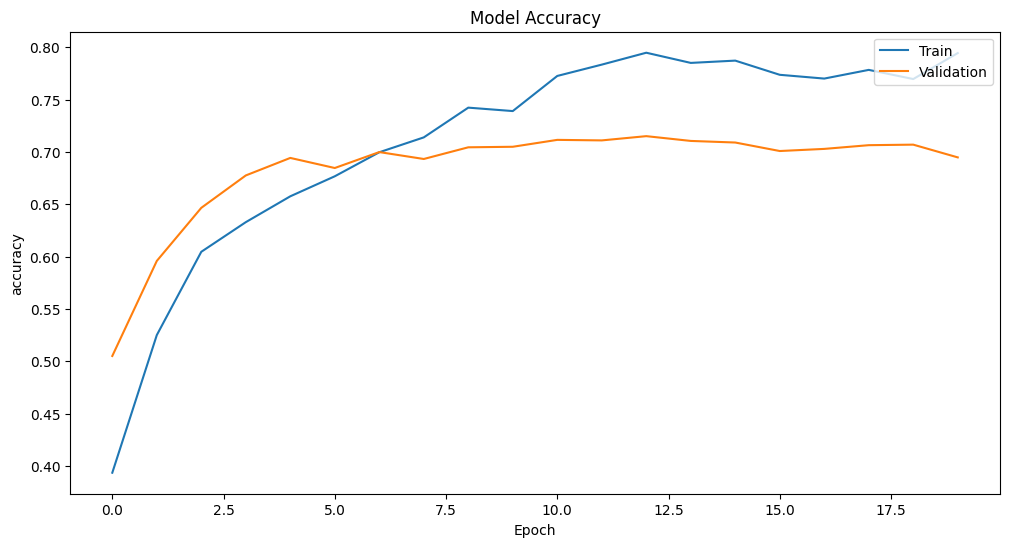

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prediction

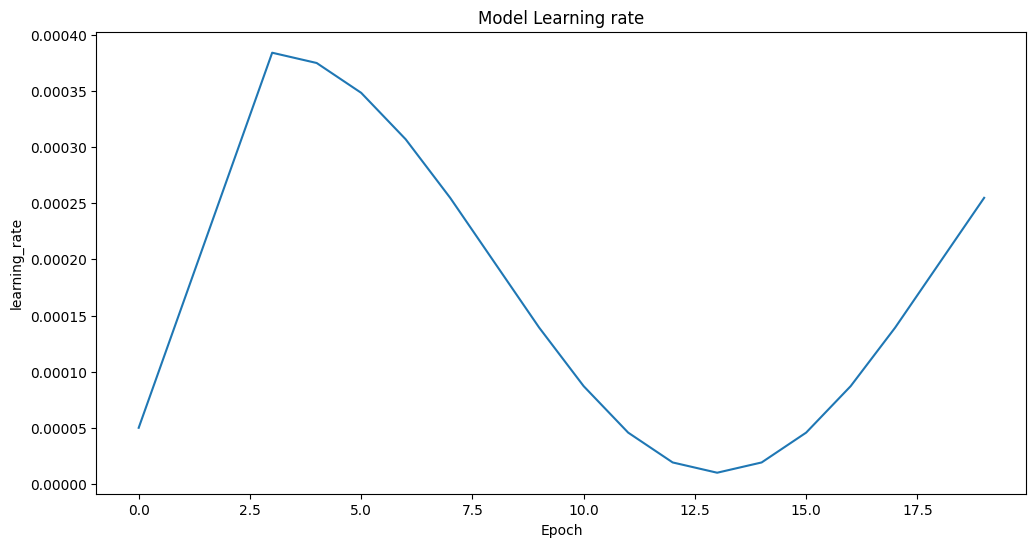

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['learning_rate'])
plt.title('Model Learning rate')
plt.ylabel('learning_rate')
plt.xlabel('Epoch')
plt.show()

## Load Best Model

In [30]:
model.load_weights("best_model.keras")

## Build Test Dataset

In [31]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(Config.batchSize, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

## Inference

In [32]:
preds = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


## Submission

In [33]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in Config.classNames]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.008774,0.018436,0.0004,0.939524,0.00558,0.027286
